# Synopsis
The model must be able to read in a sequence of numbers, one number at a time, and classify that number based on all previously seen numbers.

## Project TODO Steps
 1. create dataset
  - create single signal generator class
  - create mixed signal generator class
  - create noise functions (Gaussian, OU, etc.)
 2. create network
 3. train network
 4. test network

## Parameters to test
 1. sequence length
 2. amplitude
 3. frequency (period)
 4. offset
 5. phase
 6. noise
 
## Questions to answer
 1. What would a batch look like?
 2. How many LSTM layers do we need? nodes per LSTM layer?
 3. Can we learn if our timestamps are not uniformly spaced.
 4. Should we make the LSTM layers stateful?

In [1]:
import numpy as np
import pandas as pd
from random import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Masking
from keras.layers import TimeDistributed
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

## Build a signal generator

The signal generator builds waves using the standard form:
$$x(t) = h + A\sin\left(\frac{2\pi t}{T} + \phi\right)$$
where $h$ is the height (vertical offset), $A$ is the amplitude (vertical scale), $T$ is the period (horizontal scale), and $\phi$ is the phase (horizontal offset). This give us fine grained control over how we construct our waves.

In [4]:
from discrimnn.signal import MixedSignal

(256, 46, 1) (256, 3)


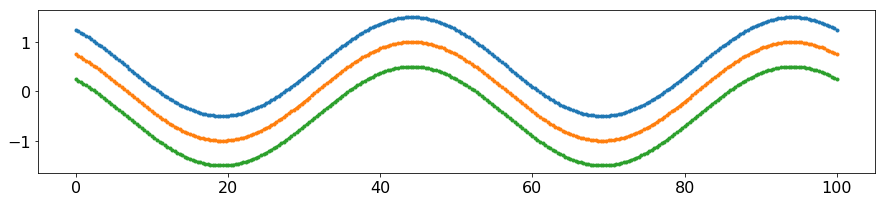

In [79]:
# start off with simplest case for proof of concept
n_timestamps = 301
n_timesteps = 46

sig1_coeffs = {'phase': {'delta': np.pi}, 'amplitude': {'mean': 1.0}, 'period': {'mean': 50.0}, 'offset': {'mean': 0.5}}
sig2_coeffs = {'phase': {'delta': np.pi}, 'amplitude': {'mean': 1.0}, 'period': {'mean': 50.0}, 'offset': {'mean': 0.0}}
sig3_coeffs = {'phase': {'delta': np.pi}, 'amplitude': {'mean': 1.0}, 'period': {'mean': 50.0}, 'offset': {'mean': -0.5}}
sig_coeffs = [sig1_coeffs, sig2_coeffs, sig3_coeffs]
msig_coeffs = {'phase': {'mean': 0, 'delta': np.pi}}
msig = MixedSignal(0, 100, n_timestamps, n_timesteps, sig_coeffs, msig_coeffs)
n_signals = len(msig)
X, y = msig()

print(X.shape, y.shape)

plt.figure(figsize=(15, 3))
for i in range(n_signals):
    plt.plot(msig.timestamps, msig.signals[i], marker='.')

In [8]:
print(y[:5])

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [7]:
def highlight_column_matches(data, column='', color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_mixed = data == data[column]
        return [attr if v else '' for v in is_mixed]
    else:  # from .apply(axis=None)
        is_mixed = data == data[column]
        return pd.DataFrame(np.where(is_mixed, attr, ''), index=data.index, columns=data.columns)
    
df = pd.DataFrame(np.vstack((msig.signals, msig.mixed_signal)).T, index=msig.timestamps, columns=['A', 'B', 'C', 'Mixed'])
df[:5].style.apply(highlight_column_matches, column='Mixed', color='lightblue', axis=1)

,A,B,C,Mixed
0.0,0.182168,-0.317832,-0.817832,0.182168
0.5,0.123261,-0.376739,-0.876739,-0.376739
1.0,0.0658402,-0.43416,-0.93416,-0.93416
1.5,0.0101329,-0.489867,-0.989867,-0.989867
2.0,-0.043641,-0.543641,-1.04364,-0.043641
2.5,-0.0952695,-0.595269,-1.09527,-1.09527
3.0,-0.144549,-0.644549,-1.14455,-1.14455
3.5,-0.191284,-0.691284,-1.19128,-0.691284
4.0,-0.235291,-0.735291,-1.23529,-0.735291
4.5,-0.276397,-0.776397,-1.2764,-0.276397


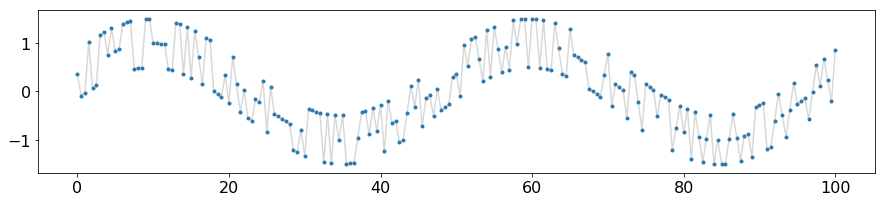

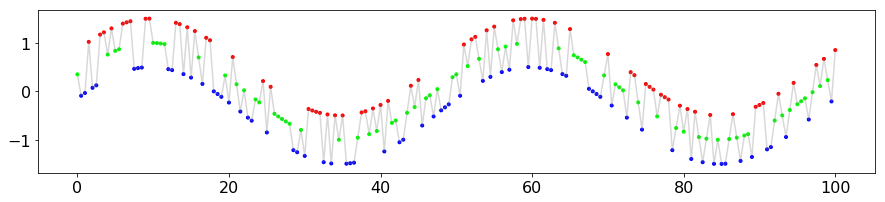

In [23]:
plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
plt.scatter(msig.timestamps, msig.mixed_signal, marker='.')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
plt.scatter(msig.timestamps, msig.mixed_signal, marker='.', c=msig.one_hots)
plt.show()

In [139]:
n_neurons = 64
n_layers = 1
batch_size = 4
# define model
model = Sequential()
# model.add(Masking(mask_value=-1, input_shape=(1,)))
# model.add(LSTM(n_neurons))
# model.add(LSTM(n_neurons, input_shape=(2, 1)))
model.add(LSTM(n_neurons, batch_input_shape=(batch_size, n_timesteps, 1), stateful=True, return_sequences=True))
# model.add(LSTM(n_neurons, batch_input_shape=(n_timesteps, 1, 1), stateful=True, return_sequences=True))
# model.add(LSTM(n_neurons, batch_input_shape=(n_timesteps, 1, 1), stateful=True))
# for _ in range(n_layers):
#     model.add(LSTM(n_neurons, stateful=True, return_sequences=True))
model.add(LSTM(n_neurons, stateful=True, return_sequences=True))
# model.add(LSTM(n_neurons, input_shape=(n_timesteps, 2)))
# model.add(Dense(n_signals, activation='softmax'))
# model.add(Reshape((n_signals, 1, n_neurons)))
model.add(TimeDistributed(Dense(n_signals, activation='softmax')))

# model.add(LSTM(32, return_sequences=True, input_shape=(timesteps, data_dim)))
# model.add(LSTM(32, return_sequences=True))
# model.add(LSTM(32))

# model.add(LSTM(2048, return_sequences=False, input_shape=self.input_shape, dropout=0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()
for i in range(50):
#     X, y = msig.generate_batch(64)
    X, y = msig.generate()
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (4, 46, 64)               16896     
_________________________________________________________________
lstm_71 (LSTM)               (4, 46, 64)               33024     
_________________________________________________________________
time_distributed_1 (TimeDist (4, 46, 3)                195       
Total params: 50,115
Trainable params: 50,115
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking target: expected time_distributed_1 to have 3 dimensions, but got array with shape (256, 3)

(256, 46, 1)
(256, 3)
256/256 [==============================] - 1s 5ms/step
[0.2636539893514964, 0.890625]
(256, 3)
(256,)
(256,)


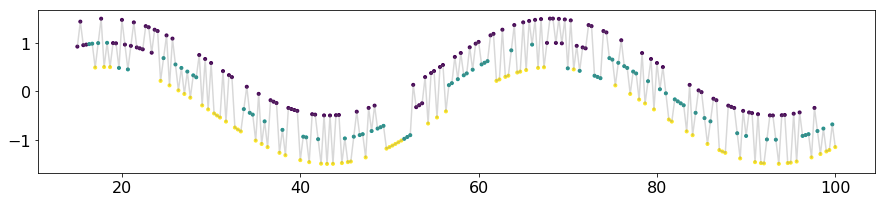

In [138]:
x_test, y_test = msig.generate()
print(x_test.shape)
print(y_test.shape)
score = model.evaluate(x_test, y_test, batch_size=batch_size)
print(score)

y_hat = model.predict(x_test, batch_size=batch_size)
print(y_hat.shape)
y_pred = np.argmax(y_hat, axis=1)
print(y_pred.shape)
y_error = 1.0 - np.max(y_hat, axis=1)
print(y_error.shape)

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
plt.scatter(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], marker='.', c=y_pred)
plt.show()

(192, 10, 1)
1
192/192 [==============================] - 1s 7ms/step
[3.730539069131733, 0.5416666666666666]


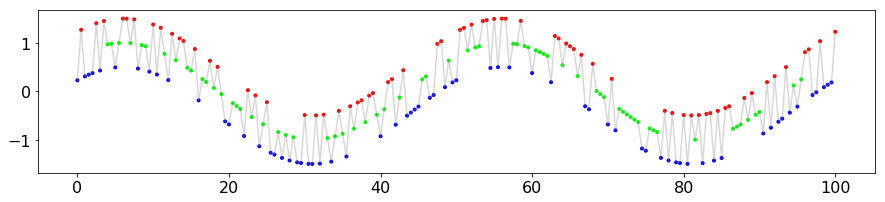

In [43]:
n_batch = 1
print(X.shape)
print(n_batch)
# re-define model
new_model = Sequential()
new_model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
new_model.add(LSTM(n_neurons))
new_model.add(Dense(n_signals, activation='softmax'))
# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)
new_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

x_test, y_test = msig.generate()
score = new_model.evaluate(x_test, y_test, batch_size=n_batch)
print(score)

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
plt.scatter(msig.timestamps, msig.mixed_signal, marker='.', c=msig.one_hots)
plt.show()

In [26]:
y_hat = new_model.predict(x_test, batch_size=msig.n_samples)
for i in range(len(x_test)):
    print('Expected', y_test[i], 'Predicted', y_hat[i])

Expected [1. 0. 0.] Predicted [9.9883705e-01 1.1629082e-03 1.7882735e-12]
Expected [0. 1. 0.] Predicted [2.5984431e-03 9.9738735e-01 1.4289385e-05]
Expected [0. 1. 0.] Predicted [5.6951577e-03 9.9429852e-01 6.4410106e-06]
Expected [1. 0. 0.] Predicted [9.9999750e-01 2.5395332e-06 3.7172947e-17]
Expected [1. 0. 0.] Predicted [9.9999177e-01 8.1663693e-06 2.4268537e-16]
Expected [1. 0. 0.] Predicted [9.9999642e-01 3.5168462e-06 6.4008400e-17]
Expected [0. 0. 1.] Predicted [3.6853123e-10 2.6589973e-02 9.7341001e-01]
Expected [0. 0. 1.] Predicted [9.3764219e-10 8.1383266e-02 9.1861677e-01]
Expected [0. 0. 1.] Predicted [1.6576672e-07 7.8178322e-01 2.1821660e-01]
Expected [1. 0. 0.] Predicted [9.9999964e-01 3.1248584e-07 4.2225659e-18]
Expected [1. 0. 0.] Predicted [9.9999976e-01 2.5084819e-07 1.5349992e-18]
Expected [0. 1. 0.] Predicted [2.5667462e-01 7.4332523e-01 1.8171546e-07]
Expected [0. 1. 0.] Predicted [4.1977692e-01 5.8022308e-01 4.2127404e-08]
Expected [0. 1. 0.] Predicted [7.61627

Expected [0. 1. 0.] Predicted [1.7869204e-05 9.9243790e-01 7.5442102e-03]
Expected [0. 1. 0.] Predicted [4.4936996e-06 9.8648190e-01 1.3513681e-02]
Expected [0. 0. 1.] Predicted [4.4953028e-16 1.0550772e-05 9.9998939e-01]
Expected [1. 0. 0.] Predicted [9.9991071e-01 8.9225789e-05 4.5601364e-13]
Expected [1. 0. 0.] Predicted [9.9998176e-01 1.8265129e-05 1.0510632e-14]
Expected [1. 0. 0.] Predicted [9.9389291e-01 6.1071264e-03 5.6604132e-10]
Expected [0. 0. 1.] Predicted [2.7425919e-14 1.2035963e-05 9.9998796e-01]
Expected [0. 0. 1.] Predicted [2.7303468e-15 4.0934892e-06 9.9999595e-01]
Expected [0. 1. 0.] Predicted [3.996390e-03 9.958903e-01 1.133268e-04]
Expected [1. 0. 0.] Predicted [9.9999917e-01 8.0654200e-07 7.1547695e-17]
Expected [0. 1. 0.] Predicted [5.5901376e-03 9.9434644e-01 6.3436746e-05]
Expected [0. 0. 1.] Predicted [4.1989063e-13 1.9360581e-04 9.9980646e-01]
Expected [0. 1. 0.] Predicted [2.6178980e-04 9.9895525e-01 7.8294234e-04]
Expected [1. 0. 0.] Predicted [9.999757e-

(192, 10, 1)
(192, 3)
(192, 3)
(192,)
(192,)


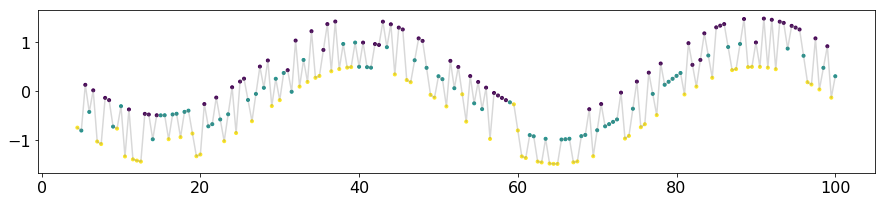

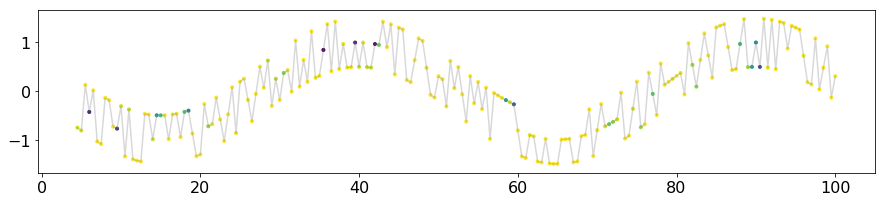

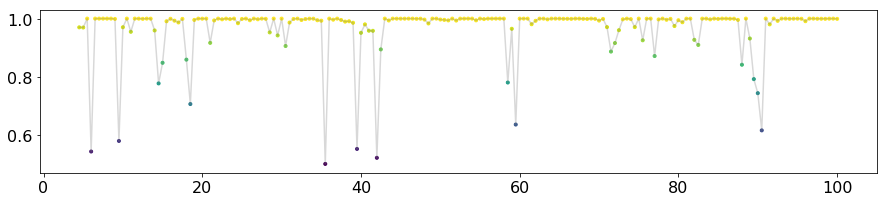

In [38]:
x_test, y_test = msig()
print(x_test.shape)
print(y_test.shape)
y_hat = new_model.predict(x_test, batch_size=msig.n_samples)
print(y_hat.shape)
y_pred = np.argmax(y_hat, axis=1)
print(y_pred.shape)
y_error = np.max(y_hat, axis=1)
print(y_error.shape)

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
plt.scatter(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], marker='.', c=y_pred)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
plt.scatter(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], marker='.', c=y_error)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[-msig.n_samples:], y_error, color='grey', alpha=0.3)
plt.scatter(msig.timestamps[-msig.n_samples:], y_error, marker='.', c=y_error)
plt.show()